In [13]:
import copy
import sys
import time
sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')
sys.path.append('/home/diego/python/utils/')

import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy.io import loadmat
import torch
from torch.optim import Adam

from gglm.glm.holi import MMDGLM
# from gglm.glm.mmdglm import MMDGLM
from gglm.glm.cimmdglm import CIMMDGLM
from gglm.glm.torchglm import TorchGLM
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from kernel.values import KernelBasisValues
from gglm.metrics import time_rescale_transform

from signals import auto_covariance

import myplt

%load_ext autoreload
%autoreload 2

# import matplotlib as mpl
# from nips import *
# for key, val in paper.items():
#     mpl.rcParams[key] = val
# palette = dict(d='C0', ml='C2', mmd='C1')    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def plot_layout():
    fig = plt.figure(figsize=(12, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43)

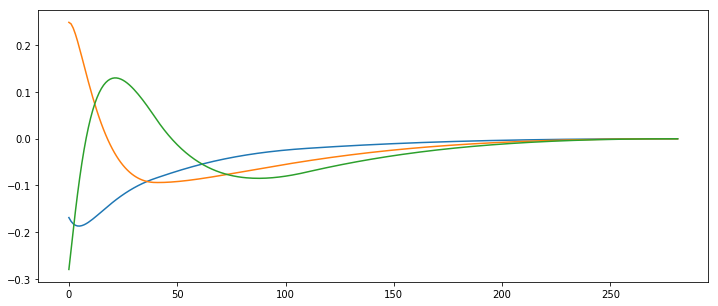

In [15]:
def raised_cosine(t, b, c, dc, a=1e0):
    basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
    basis = basis / np.sqrt(np.sum(basis**2, 0))
    u, s, v = np.linalg.svd(basis)
    basis = u[:, :basis.shape[1]]
    return basis

dt = 1
n = 3
last_peak = 40
b = last_peak / 5

peak0 = 0

yrnge = np.log(np.array([0, last_peak]) + b)
db = np.diff(yrnge) / (n - 1)
ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
mxt = np.exp(yrnge[1] + 2 * db) - b
t_ker = np.arange(0, mxt[-1] + dt, dt)
# t_ker = np.arange(0,)

basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t_ker, basis)

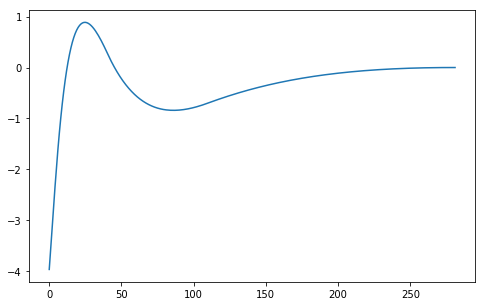

In [16]:
eta_true = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([4., -2., 10.]))
eta_true.plot(t=t_ker)

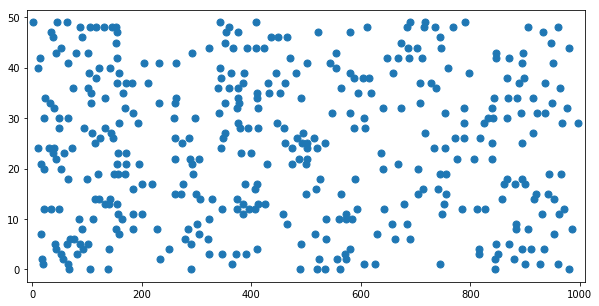

In [17]:
t = np.arange(0, 1000, 1)
np.random.seed(0)
n = 50
glm_true = TorchGLM(u0=-4.5, eta=eta_true)
_, _, mask_spikes = glm_true.sample(t, shape=(n, ))
st = SpikeTrain(t, mask_spikes)
n_spk = np.sum(mask_spikes)
fr = np.mean(np.sum(mask_spikes, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes)
autocov = np.mean(auto_covariance(mask_spikes, method='fft', subtract_mean=False, 
                                         stationary_signal=False, biased=False), 1)
isi = st.isi_distribution()
mean_isi = np.mean(isi)

fig, ax = plt.subplots(figsize=(10, 5))
st.plot(ax=ax)

In [18]:
lr = 1e-1
num_epochs = 200
metrics_kwargs = dict(n_batch_fr=60)
n_metrics = 10

u00 = -6
eta0 = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([1., -3., 5.]))

glm = TorchGLM(u0=u00, eta=eta0.copy(), noise='bernoulli')
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st.t, st.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=None)
loss_ml = np.array(loss_ml)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk

_, r_dc_ml = glm.sample_conditioned(st.t, st.mask)
_, _, mask_spikes_ml = glm.sample(st.t, shape=(100, ))
# phi_d = phi_autocov(st.t, torch.from_numpy(r_dc_ml), glm)
# mmd_ml = []
# for ii in range(20):
#     _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st.t, shape=(st.mask.shape[1],))
#     phi_fr = phi_autocov(st.t, torch.from_numpy(r_fr_ml), glm)
#     mmd_ml.append(torch.sum((torch.mean(phi_d, 1) - torch.mean(phi_fr, 1))**2).detach().numpy())

# mean_mmd_ml = np.mean(mmd_ml)
# sd_mmd_ml = np.std(mmd_ml)
# se_mmd_ml = sd_mmd_ml / len(mmd_ml)

 epoch 199 of 200 nll 2261.9423

In [19]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T = st.t[-1] - st.t[0] + st.t[1]
    u_dc, r_dc = model.sample_conditioned(st.t, st.mask)
    nll = -(np.sum(np.log(1 - np.exp(-dt * r_dc[st.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc[~st.mask]))
    return dict(nll=nll)

In [20]:
# from torch.nn.functional import conv1d

# def phi_id(t, r):
#     return r * 1000

# def kernel_id(t, r1, r2):
#     return torch.sum(r1[:, :, None] * 1000 * r2[:, None, :] * 1000, 0)

# def phi_mean(t, r):
#     return torch.mean(r, 0)[None, :] * 1000

# def phi_sum(t, r):
#     return torch.sum(r  * 1000, 0)[None, :]

# def phi_autocov(t, r, model):
#     T = len(t)
#     eta = torch.log(r) - model.b
#     padding = 500
#     autocov = conv1d(eta.T[None, :, :], eta.T[:, None, :], padding=padding, groups=eta.shape[1]) / T
#     autocov = autocov[0, :, (padding-1):].T
#     return autocov

### MMD

In [21]:
def phi_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    return torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T

def ker_fr(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    return fr1[:, None] * fr2[None, :]

def ker_sch_heavi(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    cum1 = torch.cumsum(mask_spikes1, dim=0)
    cum2 = torch.cumsum(mask_spikes2, dim=0)
    gramian = torch.exp(-torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0) / sd2)
    return gramian

dic_ker_strings = {'phi_fr': "fr*fr'", 'ker_fr': "fr*fr'"}
dic_ker_name = {'phi_fr': "product", 'ker_fr': 'product', 'phi_sum': "sum_product", 
               'kernel_expr': "gaussian", 'kernel_id': "canonical_dot"}

In [22]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_fr, None, 1e-2, False, 1e-2, 1e0
# phi, kernel, lam_mmd, biased, lr, clip = None, ker_fr, 1e1, True, 5e-3, 1e0
# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 1e-2, 1e0, 1e4

# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 1e-2, 1e0, 5e3 # 1st

phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 2e-2, 1e0, 5e3 # bueno 

beta0, beta1 = 0, 0
n_batch_fr = 200
num_epochs = 300
n_metrics = 1

time0 = time.time()
# u00 = -6
# eta0 = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([1., -3., 5.]))

u00 = glm.u0 * 1.2
eta0 = glm.eta.copy()
eta0.coefs = eta0.coefs * 1.2

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes), phi=phi, kernel=kernel, 
                                                log_likelihood=False, 
                                              n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_mmd = (metrics_mmd['nll'] - nll_pois_proc_train) / np.log(2) / n_spk
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st.t, shape=(st.mask.shape[1],))
st_fr_mmd = SpikeTrain(st.t, mask_spikes_fr_mmd)

# _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
# isi_fr_mmd = st_fr_mmd.isi_distribution()
# mean_isi_fr_mmd = np.mean(isi_fr_mmd)
# r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

# _, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(st_train.mask.shape[1],))
# st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
# isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
# mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
# r_fr_mmd_long = r_fr_mmd_long * 1000
# autocov_mmd_long = np.mean(auto_covariance(mask_spikes_fr_mmd_long, method='fft', 
#                                            subtract_mean=False, stationary_signal=False, biased=False), 1)

# time1 = time.time()
# print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 8 of 300 loss -114.9649460222

KeyboardInterrupt: 

In [17]:
gramian_d_d = kernel(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes))
idx_fr = np.triu_indices(mask_spikes_ml.shape[1], k=1)
idx_fr = (torch.from_numpy(idx_fr[0]), torch.from_numpy(idx_fr[1]))
idx_d = np.triu_indices(mask_spikes.shape[1], k=1)
idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))

mmd_ml = []

for ii in range(20):
    _, _, mask_spikes_ml = glm.sample(st.t, shape=(n_batch_fr, ))

    gramian_fr_fr = kernel(t, torch.from_numpy(mask_spikes_ml), torch.from_numpy(mask_spikes_ml))
    gramian_d_fr = kernel(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes_ml))

    if not biased:
        _mmd_ml = torch.mean(gramian_d_d.detach()[idx_d]) + torch.mean(gramian_fr_fr.detach()[idx_fr]) \
                          - 2 * torch.mean(gramian_d_fr.detach())
    else:
        _mmd_ml = torch.mean(gramian_d_d.detach()) + torch.mean(gramian_fr_fr.detach()) \
                          - 2 * torch.mean(gramian_d_fr.detach())
    mmd_ml.append(_mmd_ml)
    
mean_mmd_ml = np.mean(mmd_ml)
sd_mmd_ml = np.std(mmd_ml)
se_mmd_ml = sd_mmd_ml / np.sqrt(len(mmd_ml))

### plot

In [92]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

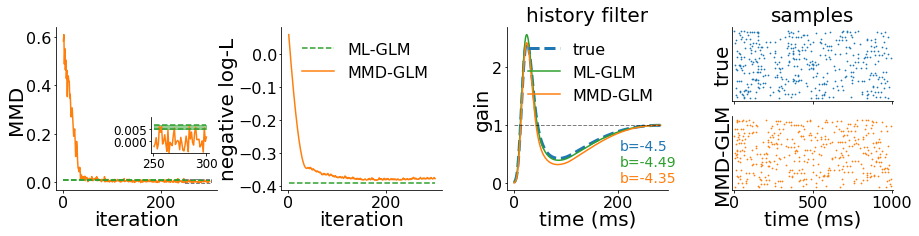

In [93]:
nrows, ncols = 2, 4

fig = plt.figure(figsize=(20 * 0.75, 4 * 0.75))
ax1 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=nrows)
ax2 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=nrows)
ax3 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=nrows)
ax4 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=1)
ax5 = plt.subplot2grid((nrows, ncols), (1, 3), rowspan=1, sharex=ax4)

ax1.plot(iterations_mmd, metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
# ax1.plot([1, num_epochs], [mean_mmd_ml, mean_mmd_ml], label='ML-GLM', color=palette['ml'])
ax1.plot([1, num_epochs], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
ax1.plot([1, num_epochs], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
# # ax1.fill_between([1, num_epochs], mean_mmd_ml - sd_mmd_ml, mean_mmd_ml + sd_mmd_ml, alpha=0.5, label='ML-GLM', color=palette['ml'])
ax1.set_xlabel('iteration')
ax1.set_ylabel('MMD')
axins1 = inset_axes(ax1, width=0.8, height=0.5, bbox_to_anchor=(.3, .1, .7, .4),
                   bbox_transform=ax1.transAxes)
i0 = 50
axins1.plot(iterations_mmd[-i0:], metrics_mmd['mmd'][-i0:], color=palette['mmd'])
axins1.plot([iterations_mmd[-i0], iterations_mmd[-1]], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
axins1.plot([iterations_mmd[-i0], iterations_mmd[-1]], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
axins1.fill_between([iterations_mmd[-i0], iterations_mmd[-1]], mean_mmd_ml - se_mmd_ml, mean_mmd_ml + se_mmd_ml, alpha=0.5, color=palette['ml'])
axins1.set_yticks([0, 5e-3])
# axins1.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=False)
axins1.tick_params(axis='both', labelsize=12)
axins1.set_ylim(-5e-3, 1e-2)
ax1.indicate_inset_zoom(axins1, lw=1, alpha=1, linestyle='--')

ax2.plot([1, num_epochs], [nll_normed_ml[-1], nll_normed_ml[-1]], '--', label='ML-GLM', color=palette['ml'])
ax2.plot(iterations_mmd, nll_normed_mmd, label='MMD-GLM', color=palette['mmd'])
# ax2.plot([1, num_epochs], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
# ax2.plot([1, num_epochs], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
# myplt.set_labels(ax2, xlabel='iteration', ylabel='negative log-L (bits/spk)')
myplt.set_labels(ax2, xlabel='iteration', ylabel='negative log-L')
ax2.legend(frameon=False)

lw = 1.5
glm_true.eta.plot(t=t_ker, ax=ax3, exp_values=True, lw=3, linestyle='--', label='true', color=palette['d'])
glm.eta.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, label='MMD-GLM', color=palette['mmd'])
ax3.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', lw=1, alpha=0.5)
ax3.set_title('history filter')
ax3.set_xlabel('time (ms)'); ax3.set_ylabel('gain')
ax3.legend(frameon=False)
b_size = 14
ax3.text(0.7, 0.25, 'b=' + str(np.round(glm_true.u0, 2)), color=palette['d'], transform=ax3.transAxes, fontsize=b_size)
ax3.text(0.7, 0.15, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax3.transAxes, fontsize=b_size)
ax3.text(0.7, 0.05, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax3.transAxes, fontsize=b_size)

ms = 1.5
ax4.set_title('samples')
ax4.set_ylabel('true')
st.plot(ax=ax4, marker='.', ms=ms, color=palette['d'])
st_fr_mmd.plot(ax=ax5, marker='.', ms=ms, color=palette['mmd'])
ax5.set_xlabel('time (ms)')
ax5.set_ylabel('MMD-GLM')

ax4.tick_params(axis='x', labelbottom=False)
ax4.set_yticks([])
ax5.set_yticks([])

# fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig2a.pdf', transparent=True, bbox_inches='tight')

In [36]:
glm_true.u0, glm.u0, mmdglm.u0

(-4.5, -4.4944071769714355, -4.3532891273498535)

In [85]:
dic = dict(iterations_mmd=iterations_mmd, mmd=metrics_mmd['mmd'], nll_normed_mmd=nll_normed_mmd, nll_normed_ml=nll_normed_ml, 
           mean_mmd_ml=mean_mmd_ml, se_mmd_ml=se_mmd_ml, t_ker=t_ker, u0_ml=glm.u0, u0_coefs_ml=glm.eta.coefs, u0_mmd=mmdglm.u0, u0_coefs_mmd=mmdglm.eta.coefs, 
           eta_coefs_ml=glm.eta.coefs, mask_spikes=st.mask, mask_spikes_mmd=st_fr_mmd.mask)

import pickle
path = './fig2a'
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)

### CIMMD

In [9]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 5e3, True, 5e-2, 1e0

# beta0, beta1 = 0, 0
# n_batch_fr = 50
# n_metrics = 1
# num_epochs = 50

# time0 = time.time()
# u00 = -6
# eta0 = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([1., -3., 5.]))

# mmdglm = CIMMDGLM(u0=u00, eta=eta0)
# optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

# loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes), phi=phi, kernel=kernel, 
#                                                 log_likelihood=False, score_term=False,
#                                                n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
#                                                 num_epochs=num_epochs, 
#                                               verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
# loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
# nll_normed_mmd = (metrics_mmd['nll'] - nll_pois_proc_train) / np.log(2) / n_spk
# metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
# iterations_mmd = np.arange(1, num_epochs + 1, 1)

# # _, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
# # z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
# # values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
# # z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

# # _, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
# _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st.t, shape=(st.mask.shape[1],))
# st_fr_mmd = SpikeTrain(st.t, mask_spikes_fr_mmd)
# # isi_fr_mmd = st_fr_mmd.isi_distribution()
# # mean_isi_fr_mmd = np.mean(isi_fr_mmd)
# # autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
# #                                            subtract_mean=False, stationary_signal=False, biased=False), 1)
# # z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
# # values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
# # z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

# # r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
# # r_dc_mmd_val = r_dc_mmd_val * 1000

# time1 = time.time()
# print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')